In [1]:
# package imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 

In [2]:
gss = pd.read_csv('Data/gss18.csv', low_memory=False)

In [3]:
interesting_variables = ['LONELY2', 'SATJOB', 'MOREDAYS', 'WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC', 'AGE','MARITAL', 'EDUC']
# testing ridding of s
# GSS rid of HOMPOP, will HOUSEHOLD SIZE use from AARP
gss = gss[interesting_variables]

## Preprocessing

In [4]:
# how many nulls?
# Loop through each column
# and check the amount of nulls.
# Only print if there are more than 0.

for col in gss.columns:
    if gss[col].isnull().sum() > 0:
        print(f'{round(gss[col].isnull().sum()/gss.shape[0],3)}%\t{gss[col].isnull().sum()} null values in {col}')

0.503%	1182 null values in LONELY2
0.259%	609 null values in SATJOB
0.403%	947 null values in MOREDAYS
0.396%	930 null values in WRKHOME
0.008%	19 null values in HLTHPHYS
0.008%	19 null values in HLTHMNTL
0.503%	1180 null values in CONWKDAY
0.503%	1182 null values in PARTLSC
0.003%	7 null values in AGE
0.001%	2 null values in MARITAL
0.001%	3 null values in EDUC


In [5]:
# recode social isolation
gss['is_si'] = gss['LONELY2'].apply(lambda x: 1 if (x == 3 or x == 4 or x == 5) else 0)

In [6]:
# bin wkdays
bins = [-1,0,7,14,21,31]#pd.IntervalIndex.from_tuples([(-1,1), (1, 7), (7, 14), (14, 21),(21,30)])


gss['MOREWEEKS'] = pd.cut(gss['MOREDAYS'],bins,labels=['0','1','2','3','4'])

In [7]:
bins = [18,29,44,59,89]#,pd.IntervaIndex.from_tuples([(18, 29), (30, 44), (45, 59),(60,89)])


gss['Age Group'] = pd.cut(gss['AGE'],bins,labels=[1,2,3,4])

####### Age group ########

In [8]:
bins= [0,11,12,15,21]
gss['EDUC'] = pd.cut(gss['EDUC'],bins,labels=[1,2,3,4])#labels=['No HS Diploma','HS Graduate','Some College','BA or Above'])
######## EDUCATION ######

## Decision Tree

In [9]:
clf = DecisionTreeClassifier(random_state=0)

In [10]:
gss = gss.dropna()
for colm in gss.columns:
    print(f'{colm}: \t{gss[colm].unique()}')

LONELY2: 	[2. 3. 1. 4. 5.]
SATJOB: 	[1. 2. 3. 4.]
MOREDAYS: 	[ 2.  1. 24.  3.  6.  0. 15. 30. 20. 12. 18.  5.  4. 10. 26. 25.  8. 28.
  7. 17. 22. 14. 23.  9. 16.]
WRKHOME: 	[1. 4. 5. 6. 2. 3.]
HLTHPHYS: 	[1. 3. 2. 4. 5.]
HLTHMNTL: 	[1. 2. 3. 4. 5.]
CONWKDAY: 	[4. 3. 2. 6. 1. 5.]
PARTLSC: 	[3. 2. 5. 1. 4.]
AGE: 	[63. 59. 43. 55. 34. 44. 40. 30. 20. 65. 46. 22. 23. 28. 37. 42. 21. 70.
 53. 29. 50. 56. 67. 54. 48. 76. 39. 69. 60. 35. 38. 26. 57. 19. 36. 61.
 33. 51. 58. 45. 52. 25. 27. 24. 77. 47. 74. 32. 31. 72. 66. 68. 49. 64.
 41. 71. 78. 75. 85. 73. 62. 89.]
MARITAL: 	[1. 3. 5. 4. 2.]
EDUC: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]
is_si: 	[0 1]
MOREWEEKS: 	['1', '4', '0', '3', '2']
Categories (5, object): ['0' < '1' < '2' < '3' < '4']
Age Group: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]


### make x and y

In [11]:
x = gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss['is_si']
x.shape

(688, 10)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)#,stratify=x['MOREWEEKS'])

In [13]:
# decision tree regular fit
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.6447368421052632

In [14]:
# baseline
gss['is_si'].value_counts()[0]/gss['is_si'].value_counts().sum()
# 79% baseline. awkward.

0.7558139534883721

In [15]:
# 79%... what quantities?
gss['is_si'].value_counts()

0    520
1    168
Name: is_si, dtype: int64

In [16]:
# prepare grid search
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [17]:
# do the grid search
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [18]:
CV_DT.score(x_test, y_test)

0.7631578947368421

In [19]:
x.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,MARITAL,EDUC,MOREWEEKS,Age Group
3,1.0,1.0,1.0,1.0,4.0,3.0,1.0,4,1,4
6,1.0,1.0,3.0,2.0,3.0,2.0,3.0,3,1,3
7,1.0,1.0,2.0,3.0,4.0,5.0,5.0,2,4,2
9,2.0,1.0,2.0,3.0,4.0,1.0,1.0,2,1,3
11,2.0,1.0,3.0,3.0,2.0,1.0,4.0,3,1,2


## upsampling is_si

In [20]:
to_resample = gss.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_rebal = pd.concat([gss, our_resample])

In [21]:
x = gss_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss_rebal['is_si']
x.shape

(1084, 10)

In [22]:
gss_rebal['is_si'].value_counts()

1    564
0    520
Name: is_si, dtype: int64

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [24]:
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.8379888268156425

In [25]:
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [26]:
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [27]:
CV_DT.score(x_test, y_test)

0.8184357541899442

In [28]:
x.shape

(1084, 10)

In [29]:
for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
    print(f'{round(importance,3)}\t{feature}')

0.076	SATJOB
0.077	WRKHOME
0.057	HLTHPHYS
0.135	HLTHMNTL
0.102	CONWKDAY
0.139	PARTLSC
0.171	MARITAL
0.08	EDUC
0.062	MOREWEEKS
0.102	Age Group


In [30]:
# DT for each age category
for ages in gss['Age Group'].unique():
    print(f'---------- ages {ages}-----------')
    age_gss = gss_rebal.loc[gss_rebal['Age Group'] == ages]
    x = age_gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    y = age_gss['is_si']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    clf.fit(x_train,y_train)
    print(f'{round(clf.score(x_test, y_test),3)}% {ages}')
    
    for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')

---------- ages 4-----------
0.84% 4
0.048	SATJOB
0.088	WRKHOME
0.122	HLTHPHYS
0.361	HLTHMNTL
0.108	CONWKDAY
0.068	PARTLSC
0.023	MARITAL
0.08	EDUC
0.102	MOREWEEKS
0.0	Age Group
---------- ages 3-----------
0.804% 3
0.031	SATJOB
0.043	WRKHOME
0.115	HLTHPHYS
0.27	HLTHMNTL
0.113	CONWKDAY
0.103	PARTLSC
0.07	MARITAL
0.115	EDUC
0.139	MOREWEEKS
0.0	Age Group
---------- ages 2-----------
0.891% 2
0.062	SATJOB
0.144	WRKHOME
0.073	HLTHPHYS
0.112	HLTHMNTL
0.091	CONWKDAY
0.145	PARTLSC
0.214	MARITAL
0.04	EDUC
0.119	MOREWEEKS
0.0	Age Group
---------- ages 1-----------
0.811% 1
0.072	SATJOB
0.116	WRKHOME
0.164	HLTHPHYS
0.144	HLTHMNTL
0.037	CONWKDAY
0.073	PARTLSC
0.107	MARITAL
0.122	EDUC
0.165	MOREWEEKS
0.0	Age Group


[Text(0.39470591971544716, 0.96875, 'MARITAL <= 1.5\ngini = 0.499\nsamples = 726\nvalue = [344, 382]\nclass = WRKHOME'),
 Text(0.0741869918699187, 0.90625, 'HLTHMNTL <= 1.5\ngini = 0.409\nsamples = 251\nvalue = [179, 72]\nclass = SATJOB'),
 Text(0.016260162601626018, 0.84375, 'SATJOB <= 2.5\ngini = 0.086\nsamples = 67\nvalue = [64, 3]\nclass = SATJOB'),
 Text(0.008130081300813009, 0.78125, 'gini = 0.031\nsamples = 63\nvalue = [62, 1]\nclass = SATJOB'),
 Text(0.024390243902439025, 0.78125, 'PARTLSC <= 4.0\ngini = 0.5\nsamples = 4\nvalue = [2, 2]\nclass = SATJOB'),
 Text(0.016260162601626018, 0.71875, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = WRKHOME'),
 Text(0.032520325203252036, 0.71875, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = SATJOB'),
 Text(0.13211382113821138, 0.84375, 'HLTHMNTL <= 2.5\ngini = 0.469\nsamples = 184\nvalue = [115, 69]\nclass = SATJOB'),
 Text(0.08130081300813008, 0.78125, 'MOREWEEKS <= 2.5\ngini = 0.414\nsamples = 113\nvalue = [80, 33]\nclass = SATJO

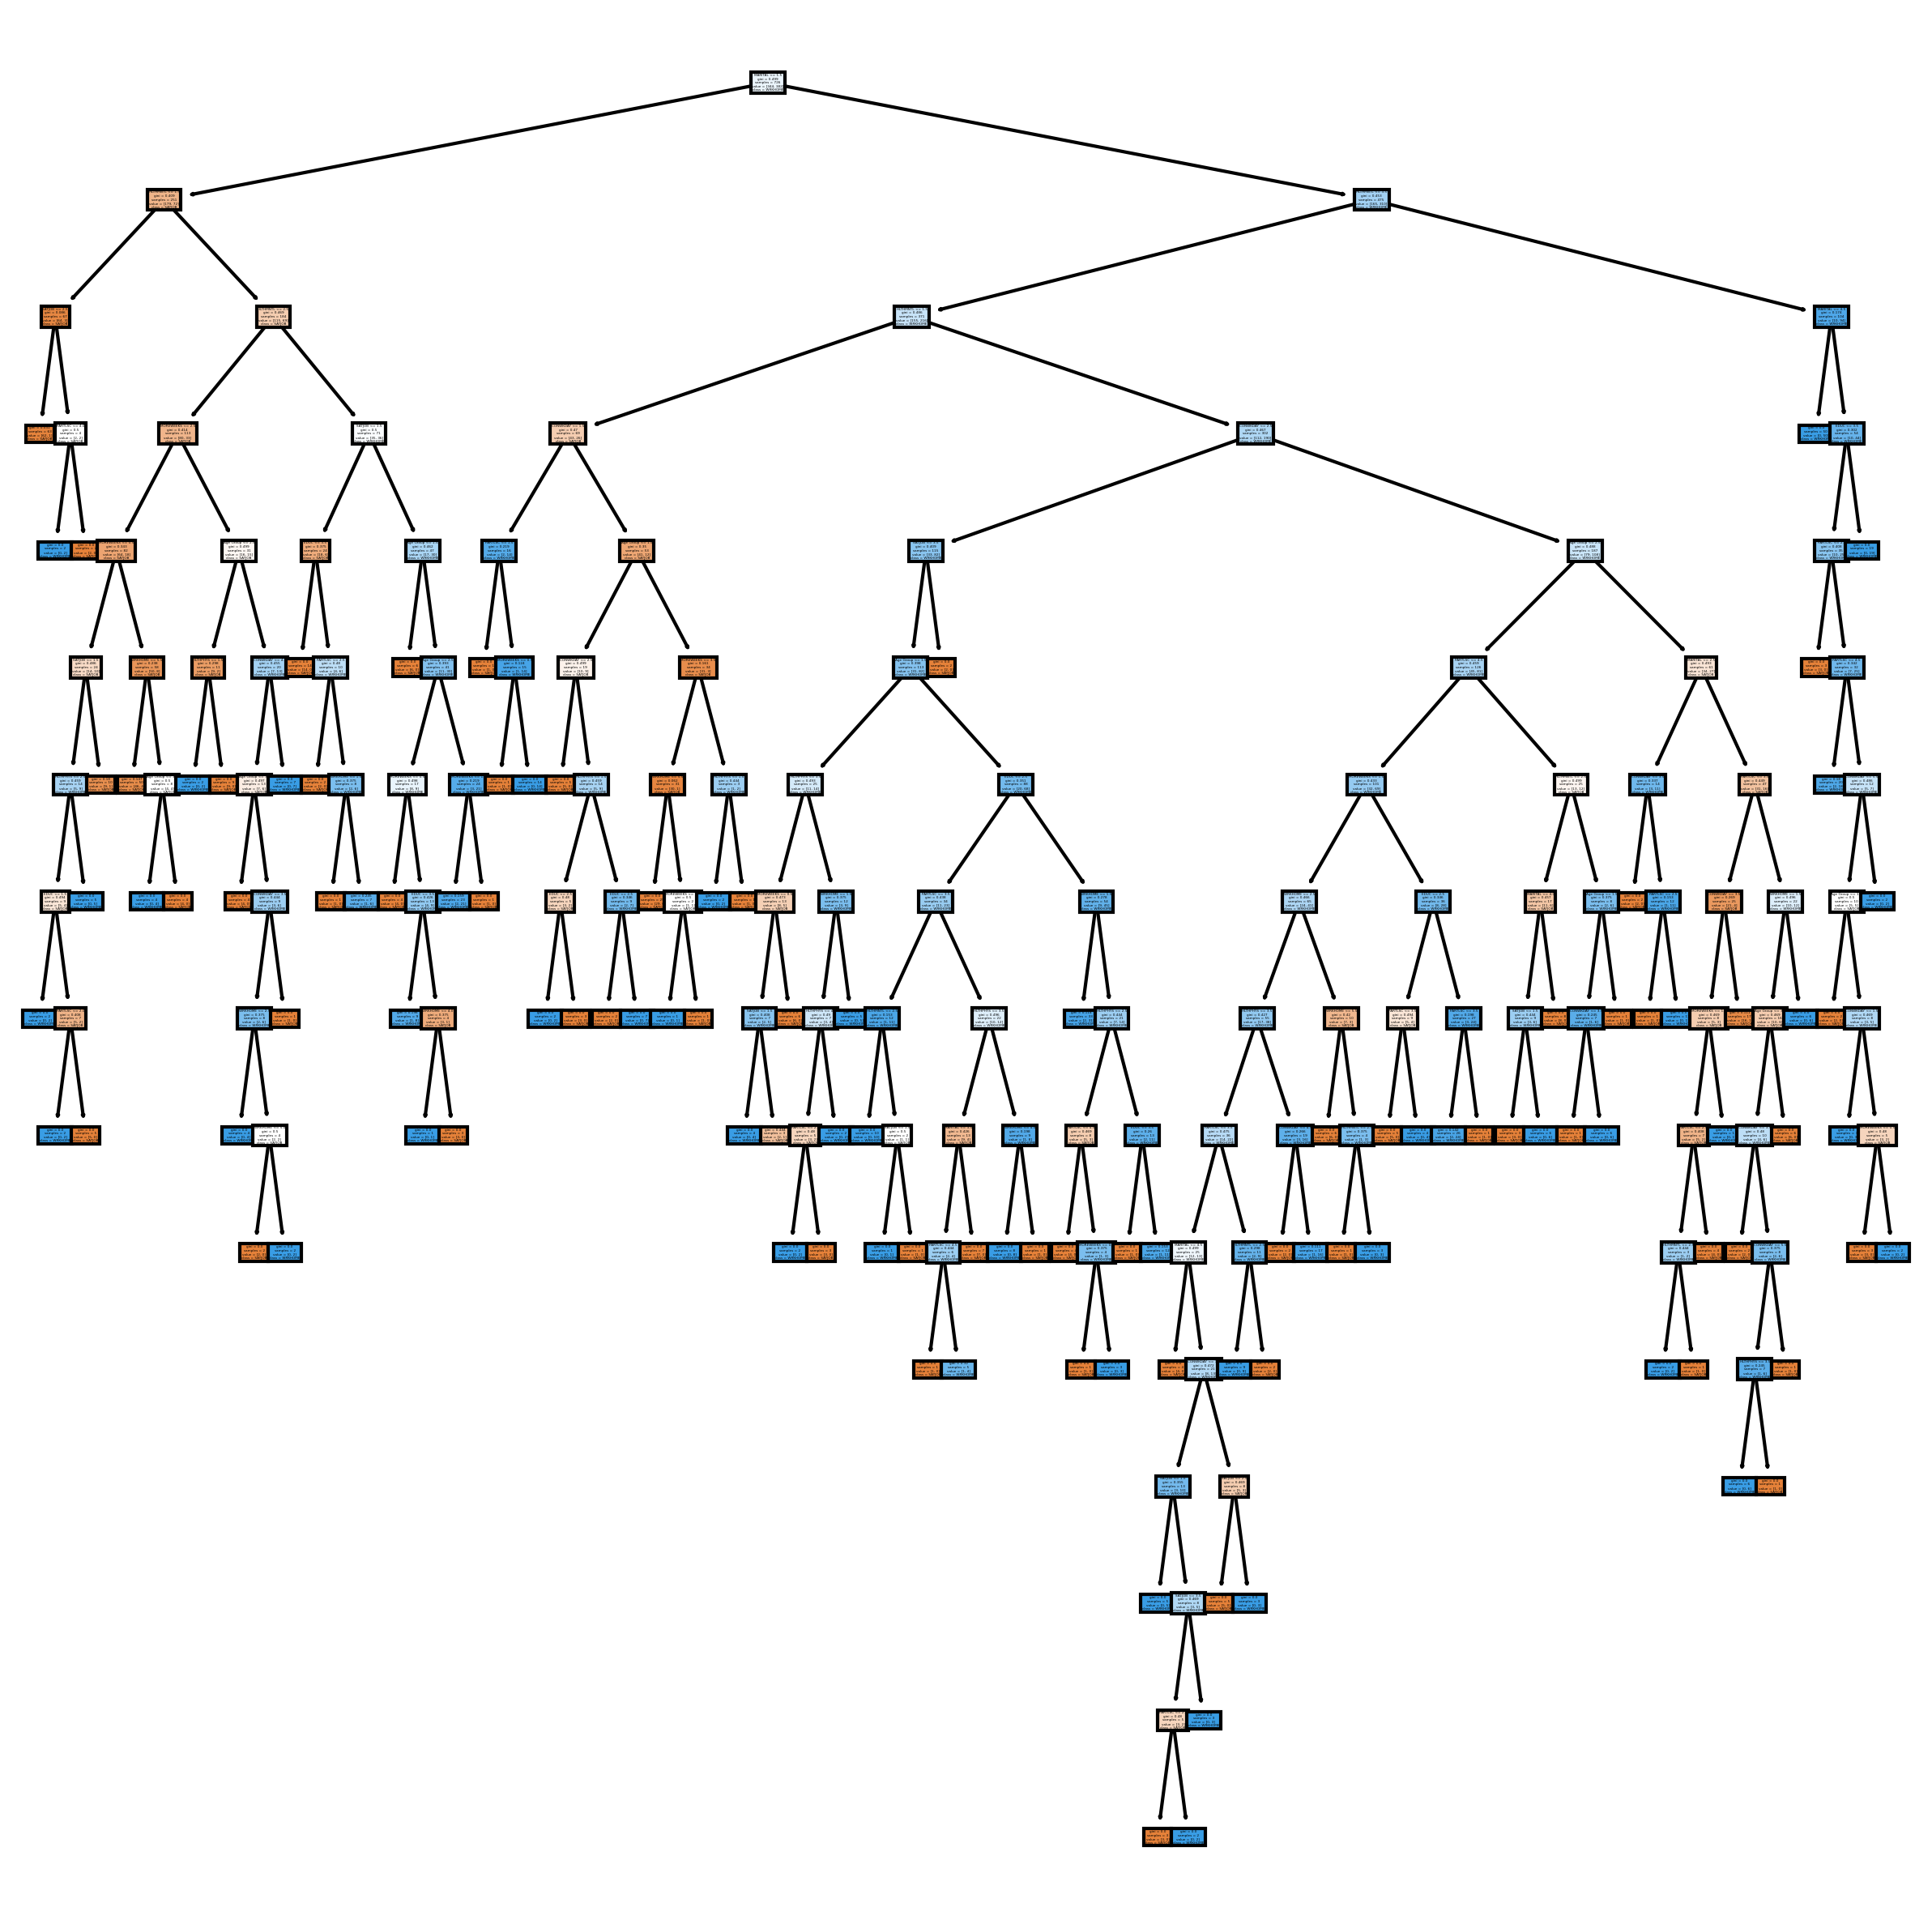

In [31]:
fix, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=300)
tree.plot_tree(CV_DT.best_estimator_, feature_names = x.columns, class_names = CV_DT.feature_names_in_, filled = True)

In [32]:
# upsample training data only CHECK
# fix tree????
# trim down unncessary vars?
# make output legible CHECK
# seperate modeling from data manip, gss and aarp 
# linear 

## Upsampling only training data

In [33]:
# make train and test set
gss_train, gss_test = train_test_split(gss, test_size=0.33, random_state=42)

In [34]:
# upsample train set
to_resample = gss_train.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_train_rebal = pd.concat([gss_train, our_resample])

In [35]:
# manually create x,y test and trains
x_train = gss_train_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
x_test = gss_test.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y_train = gss_train_rebal['is_si']
y_test = gss_test['is_si']

In [36]:
# grid search it yeah
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [37]:
CV_DT.score(x_test, y_test)

0.6754385964912281

In [38]:
#Creating dataframes to hold feature importances
fi_df1 = pd.DataFrame()
fi_df2 = pd.DataFrame()
fi_df3 = pd.DataFrame()
fi_df4 = pd.DataFrame()
summary_plot = pd.DataFrame()

In [39]:
from imblearn.over_sampling import SMOTEN
# DT for each age category
for ages in gss['Age Group'].unique():
    #print(f'---------- ages {ages} -----------')
    
    # grab gss for single age group
    aged_gss = gss.loc[gss['Age Group'] == ages]
    
    # split into train and test
    gss_train, gss_test = train_test_split(aged_gss, test_size=0.33, random_state=42)
    # upsample train set
    
    sm = SMOTEN(random_state=42)
    
    # manually create x,y test and trains
    x_train = gss_train.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si', 'Age Group'], axis=1)
    x_test = gss_test.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si', 'Age Group'], axis=1)
    y_train = gss_train['is_si']
    y_test = gss_test['is_si']
    
    x_train, y_train = sm.fit_resample(x_train, y_train)
    
    # new decision tree
    clf = DecisionTreeClassifier(random_state=42)
    
    # grid to search
    param_grid = { 
    'max_leaf_nodes': range(2,1000,11),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 3),
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}
    # new grid search using decision tree and grid from above
    CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 4, n_jobs=-1) 
    
    # let's 'train'
    CV_DT.fit(x_train, y_train)
    
    # print the results
    print(f'---------- score for age {ages}: {round(CV_DT.score(x_test, y_test),3)}% ----------')

    
    for importance, feature in zip(CV_DT.best_estimator_.feature_importances_, CV_DT.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')
        
        #Saving summary data to a dataframe for plots
        if ages ==1:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df1 = pd.concat([fi_df1, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)

        if ages==2:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df2 = pd.concat([fi_df2, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)
            
        if ages==3:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df3 = pd.concat([fi_df3, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)

        if ages==4:
            fi_new = {'importance': (round(importance,3)), 'feature': feature}
            fi_df4 = pd.concat([fi_df4, pd.DataFrame(fi_new, index=[feature])])#, ignore_index=True)
    ###### print train and test set sizes
    print(f'training set size: \n{y_train.value_counts()}')
    print(f'testing set size:  \n{y_test.value_counts()}')
    ###### 


---------- score for age 4: 0.667% ----------
0.04	SATJOB
0.0	WRKHOME
0.185	HLTHPHYS
0.078	HLTHMNTL
0.494	CONWKDAY
0.085	PARTLSC
0.039	MARITAL
0.041	EDUC
0.038	MOREWEEKS
training set size: 
1    49
0    49
Name: is_si, dtype: int64
testing set size:  
0    28
1     5
Name: is_si, dtype: int64
---------- score for age 3: 0.696% ----------
0.0	SATJOB
0.254	WRKHOME
0.075	HLTHPHYS
0.253	HLTHMNTL
0.066	CONWKDAY
0.0	PARTLSC
0.117	MARITAL
0.103	EDUC
0.133	MOREWEEKS
training set size: 
0    109
1    109
Name: is_si, dtype: int64
testing set size:  
0    50
1    19
Name: is_si, dtype: int64
---------- score for age 2: 0.655% ----------
0.126	SATJOB
0.041	WRKHOME
0.067	HLTHPHYS
0.078	HLTHMNTL
0.075	CONWKDAY
0.073	PARTLSC
0.414	MARITAL
0.046	EDUC
0.079	MOREWEEKS
training set size: 
0    127
1    127
Name: is_si, dtype: int64
testing set size:  
0    68
1    16
Name: is_si, dtype: int64
---------- score for age 1: 0.535% ----------
0.066	SATJOB
0.11	WRKHOME
0.127	HLTHPHYS
0.045	HLTHMNTL
0.141	CONW

In [40]:
#Add a new column in each summary dataframe that indicates the Age group of the dataframe
fi_df1['Age Group'] = '18-29'
fi_df2['Age Group'] = '30-44'
fi_df3['Age Group'] = '45-59'
fi_df4['Age Group'] = '60+'

#Create a new data frame to hold data that will be used for plotting
summary_plot = pd.concat([fi_df1,fi_df2,fi_df3,fi_df4])

In [41]:
summary_plot.replace(to_replace={'HLTHPHYS': 'Physical Health',
                         'CONWKDAY':'# of Weekday Interactions', 
                         'HLTHMNTL':'Mental Health',
                         'MOREWEEKS':'Extra Hours Worked',
                         'MARITAL':'Marital Status',
                         'PARTLSC':'Participation in groups',
                         'SATJOB':'Job Satisfaction',
                         'WRKHOME':'Work from Home',
                         'EDUC': 'Education'},inplace=True)

Text(0, 0.5, 'Feature')

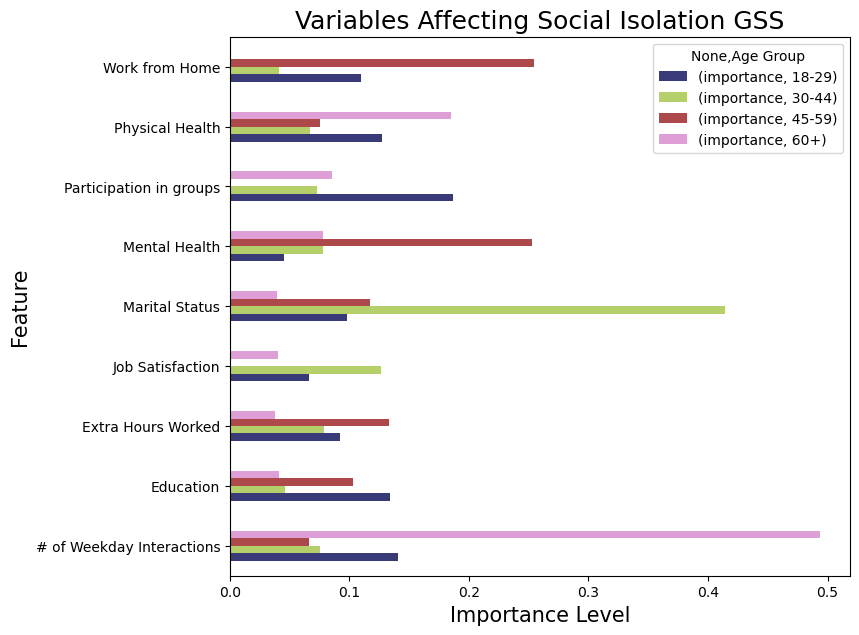

In [45]:
#plt.figure(figsize=(10,10))
ax = summary_plot.pivot(columns='Age Group', index='feature').plot.barh(figsize=(8,7),rot=0,cmap='tab20b')#


plt.title('Variables Affecting Social Isolation GSS', fontsize=18)
plt.xlabel('Importance Level',fontsize=15)
plt.ylabel('Feature',fontsize=15)
#ax.tick_params(axis='x',labelsize=12)
#ax.tick_params(axis='y', labelsize=10)
# ax.set_yticklabels(['# of Weekday Interactions', 'Mental Health', 'Physical Health','Job Overtime','Married','Participation in Groups','Job Satisfaction','Work From Home'])
#plt.setp(ax.yaxis.get_majorticklabels(), ha="right" )

In [43]:
summary_plot.pivot(index='feature',columns='Age Group')

importance                     
Age Group                      18-29  30-44  45-59    60+
feature                                                  
# of Weekday Interactions      0.141  0.075  0.066  0.494
Education                      0.134  0.046  0.103  0.041
Extra Hours Worked             0.092  0.079  0.133  0.038
Job Satisfaction               0.066  0.126  0.000  0.040
Marital Status                 0.098  0.414  0.117  0.039
Mental Health                  0.045  0.078  0.253  0.078
Participation in groups        0.187  0.073  0.000  0.085
Physical Health                0.127  0.067  0.075  0.185
Work from Home                 0.110  0.041  0.254  0.000